# Convolutional Neural Network

### Importing the libraries

In [4]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [30]:
drive.mount('/content/drive')

training_directory = '/content/drive/My Drive/4k_training_data_set'
test_directory = '/content/drive/My Drive/1k_test_data_set'
single_prediction_dir = '/content/drive/My Drive/single_prediction'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [6]:
train_datagen = ImageDataGenerator(
   rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

In [7]:
x_train = []
y_train = []  # labels for training images

for folder_name in os.listdir(training_directory):  # Iterate through class folders
    folder_path = os.path.join(training_directory, folder_name)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):  # Iterate through images in folder
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                img = load_img(file_path, target_size=(64, 64))  # Load image
                img_array = img_to_array(img)  # Convert to NumPy array
                x_train.append(img_array)  # Add to x_train list

                # have labels, add them to y_train
                y_train.append(folder_name)

x_train = np.array(x_train)  # Convert x_train list to NumPy array
y_train = np.array(y_train)  # Convert y_train list to NumPy array (if needed)

print(x_train.shape)  # Check the shape of x_train array

(8000, 64, 64, 3)


In [8]:
mean = np.mean(x_train, axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))

# Create a custom ImageDataGenerator with standardization
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: (x - mean) / std,  # Apply standardization
)

### Preprocessing the Test set

In [9]:
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: (x - mean) / std  # Apply standardization
)

training_set = train_datagen.flow_from_directory(
    training_directory,  #training directory
    target_size=(64, 64),
    batch_size=32,  # Adjust batch size if needed
    class_mode='binary',  # Change to 'categorical' for multi-class
    color_mode='rgb',
    shuffle=True  # Shuffle data during training
)

Found 8000 images belonging to 2 classes.


Load Dataset

In [10]:
training_set = train_datagen.flow_from_directory(
    training_directory,
    target_size=(64, 64),  # Resize to 64x64
    batch_size=32,
    class_mode='binary',  # Binary classification: dog vs cat
    color_mode='rgb'
)


Found 8000 images belonging to 2 classes.


In [11]:
test_set = test_datagen.flow_from_directory(
    training_directory,
    target_size=(64, 64),  # Resize to 64x64
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
     shuffle=False
)

Found 8000 images belonging to 2 classes.


## Part 2 - Building the CNN

### Initialising the CNN

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Input(shape=(64, 64, 3)))
model.add(Dropout(0.2))

### Step 1 - Convolution

In [13]:
model.add(Conv2D(32, (3, 3), activation='relu', strides=1, padding='same'))  # First convolutional layer
model.add(BatchNormalization())  # Add Batch Normalization for stability
model.add(MaxPooling2D(pool_size=(2, 2)))

### Step 2 - Pooling

In [14]:
model.add(Conv2D(64, (3, 3), activation='relu', strides=1, padding='same'))  # Second convolutional layer
model.add(BatchNormalization())  # Add Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', strides=1, padding='same'))  # Third convolutional layer (increased filters)
model.add(BatchNormalization())  # Add Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))

### Adding a second convolutional layer

In [15]:
model.add(Conv2D(256, (3, 3), activation='relu', strides=1, padding='same'))  # Fourth convolutional layer (deeper network)
model.add(BatchNormalization())  # Add Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))

### Step 3 - Flattening

In [16]:
model.add(Flatten())

### Step 4 - Full Connection

In [17]:
model.add(Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))

### Step 5 - Output Layer

In [18]:
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 914,881 (3.49 MB)

 Trainable params: 913,921 (3.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Part 3 - Training the CNN

### Compiling the CNN

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
pip install --upgrade tensorflow keras

### Training the CNN on the Training set and evaluating it on the Test set

In [21]:
history = model.fit(x=training_set, validation_data=test_set, epochs=20)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 830ms/step - accuracy: 0.5783 - loss: 2.5951 - val_accuracy: 0.5999 - val_loss: 1.1214
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 265s 840ms/step - accuracy: 0.6726 - loss: 0.9490 - val_accuracy: 0.6864 - val_loss: 0.7622
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 285s 935ms/step - accuracy: 0.7189 - loss: 0.7181 - val_accuracy: 0.7284 - val_loss: 0.7654
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 934ms/step - accuracy: 0.7547 - loss: 0.6280 - val_accuracy: 0.7935 - val_loss: 0.5894
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 931ms/step - accuracy: 0.7844 - loss: 0.5872 - val_accuracy: 0.8284 - val_loss: 0.4901
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 829ms/step - accuracy: 0.8408 - loss: 0.4749 - val_accuracy: 0.8443 - val_loss: 0.4462
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 229s 917ms/step - accuracy: 0.8437 - loss: 0.4634 - val_accuracy: 0.8393 - val_loss: 0.4626
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 834ms/step - accuracy: 0.8705 -

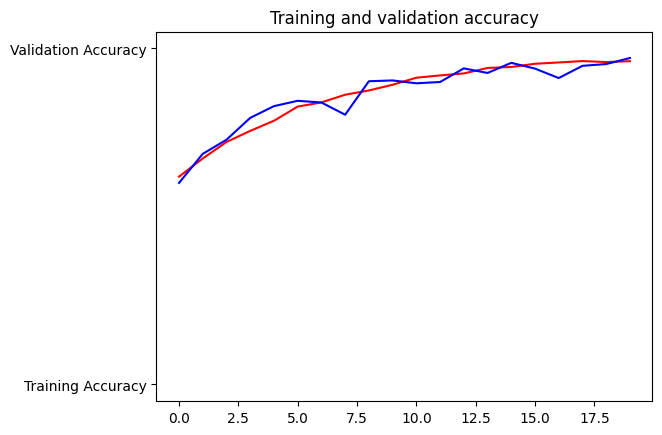

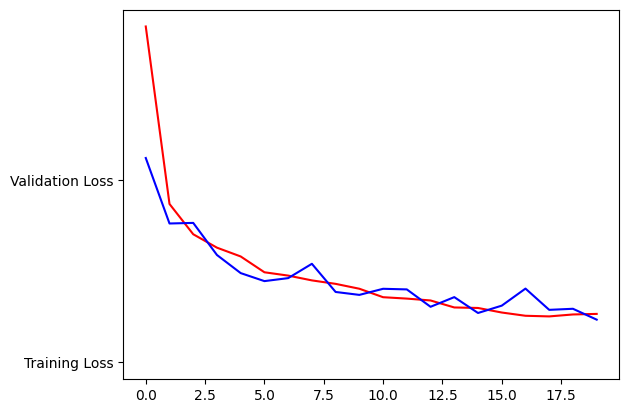

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 243ms/step
Confusion Matrix:
 [[3887  113]
 [ 114 3886]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4000
           1       0.97      0.97      0.97      4000

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000

Precision: 0.9716250294765644
Recall: 0.971625
F1-Score: 0.9716249995566406


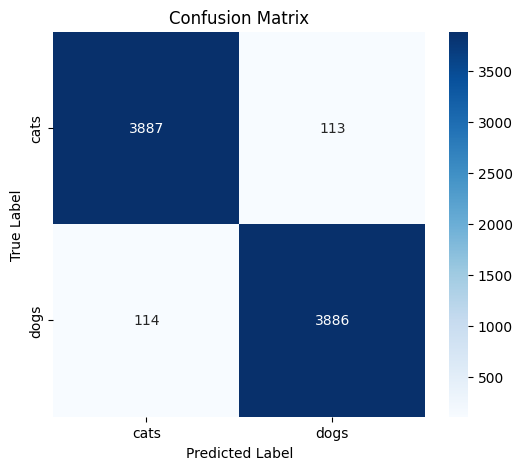

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get the model's predictions (y_pred) on the test set
y_pred_probs = model.predict(test_set, steps=int(np.ceil(test_set.samples / test_set.batch_size)), verbose=1)

# Convert predicted probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold of 0.5

# Ensure that y_true and y_pred have the same length (if necessary)
y_true = test_set.classes  # True labels

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Step 3: Classification Report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# Step 4: Individual Metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Step 5: Plot Confusion Matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Part 4 - Making a single prediction

In [32]:
pip install opencv-python

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


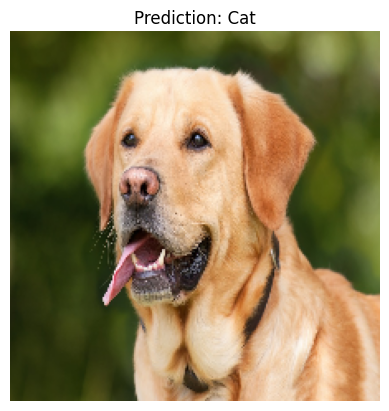

Image: cat_or_dog_1.jpg -> Prediction: Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


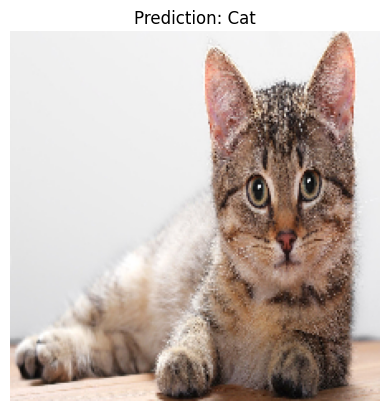

Image: cat_or_dog_2.jpg -> Prediction: Cat


In [33]:
import cv2  # Import OpenCV for resizing

def predict_image(image_path, model):
    # Load the image using OpenCV for resizing later
    original_image = cv2.imread(image_path)

    # Load and preprocess the image for prediction (using original size)
    img = image.load_img(image_path, target_size=(64, 64))  # adjust target_size if needed for model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make the prediction
    prediction = model.predict(img_array)

    # Output the prediction result
    if prediction[0][0] > 0.5:
        result = 'Dog'
    else:
        result = 'Cat'

    # Resize the original image for display
    resized_image = cv2.resize(original_image, (224, 224))  # Adjust size as needed

    # Display the resized image and prediction
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.axis('off')
    plt.title(f"Prediction: {result}")
    plt.show()

    return result

# Test predictions on images in the 'single_prediction' folder
for filename in os.listdir(single_prediction_dir):
    file_path = os.path.join(single_prediction_dir, filename)
    if os.path.isfile(file_path):
        result = predict_image(file_path, model)
        print(f"Image: {filename} -> Prediction: {result}")

**[Github Link](https://github.com/tahminasqa/image-classification-convolutional-neural-networks)**

**[Medium Link](https://medium.com/@tahminasqa/developing-an-image-classification-model-with-convolutional-neural-networks-cnns-5c4cfb6d89ae)**